In [93]:
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchmetrics
from torchmetrics import Dice, JaccardIndex
import albumentations as alb
from albumentations.pytorch import ToTensorV2  # np.array -> torch.tensor
from tqdm import tqdm
from glob import glob
import segmentation_models_pytorch as smp
import pandas as pd

In [94]:
n_classes = 6
seed = 24
batch_size = 16
epochs = 50
learning_rate = 1e-4
IMG_HEIGHT = 256
IMG_WIDTH = 256
IMG_CHANNELS = 3
input_shape = (256, 256, 3)
model_file = '../models/unet_model.torch'
train_path = "../dataset/256_patches_splitted_RF/train"
val_path = "../dataset/256_patches_splitted_RF/val"
test_path = "../dataset/256_patches_splitted_RF/test"

In [95]:
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

label_encoder = LabelEncoder()
scaler = MinMaxScaler()


class ImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        super().__init__()
        self.root_dir = root_dir
        self.transform = transform
        self.img_path_lst = []
        for file in os.listdir(os.path.join(root_dir, "images")):
            self.img_path_lst.append(file)

    def __len__(self):
        return len(self.img_path_lst)

    def __getitem__(self, idx):
        image_path = self.root_dir + "/images/" + self.img_path_lst[idx]
        mask_path = self.root_dir + "/masks/" + self.img_path_lst[idx]
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # print(image_path)
        # print(mask_path)
        mask = cv2.imread(mask_path, 0)
        # print(image.shape)
        # print(mask.shape)
        # image = scaler.fit_transform(image.reshape(-1, image.shape[-1])).reshape(image.shape)
        mask = label_encoder.fit_transform(np.ravel(mask)).reshape(mask.shape)
        if self.transform is not None:
            transformed = self.transform(image=image, mask=mask)
            image = transformed['image']
            mask = transformed['mask']
        return image, mask


In [96]:
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
            # The normalize code -> t.sub_(m).div_(s)
        return tensor


unorm = UnNormalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))

In [97]:
train_transform = alb.Compose([
    # alb.Resize(width=IMG_WIDTH, height=IMG_HEIGHT),
    alb.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0),
    ToTensorV2()
])

val_transform = alb.Compose([
    alb.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0),
    ToTensorV2()
])

test_transform = alb.Compose([
    alb.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0),
    ToTensorV2()
])

In [98]:
train_dataset = ImageDataset(train_path, transform=train_transform)
val_dataset = ImageDataset(val_path, transform=val_transform)
test_dataset = ImageDataset(test_path, transform=test_transform)
print(len(train_dataset))
print(len(val_dataset))
print(len(test_dataset))

72
24
24


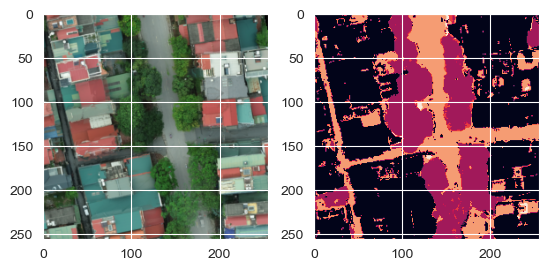

In [99]:
image, mask = train_dataset.__getitem__(50)
plt.subplot(1, 2, 1)
plt.imshow(unorm(image).permute(1, 2, 0))
plt.subplot(1, 2, 2)
plt.imshow(mask)
plt.show()

In [100]:
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
print(torch.cuda.get_device_name(torch.cuda.current_device()))

cuda
NVIDIA GeForce RTX 3050 Laptop GPU


In [101]:
class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [102]:
def accuracy_function(preds, targets):
    preds_flat = preds.flatten()
    targets_flat = targets.flatten()
    acc = torch.sum(preds_flat == targets_flat)
    return acc / targets_flat.shape[0]

In [103]:
def unet_block(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, 1, 1),
        nn.ReLU(),
        nn.Conv2d(out_channels, out_channels, 3, 1, 1),
        nn.ReLU()
    )


class UNet(nn.Module):
    def __init__(self, num_class):
        super().__init__()
        self.num_class = num_class
        self.downsample = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode="bilinear")
        self.block_down1 = unet_block(3, 64)
        self.block_down2 = unet_block(64, 128)
        self.block_down3 = unet_block(128, 256)
        self.block_down4 = unet_block(256, 512)
        self.block_neck = unet_block(512, 1024)
        self.block_up1 = unet_block(1024 + 512, 512)
        self.block_up2 = unet_block(256 + 512, 256)
        self.block_up3 = unet_block(128 + 256, 128)
        self.block_up4 = unet_block(128 + 64, 64)
        self.conv_cls = nn.Conv2d(64, self.num_class, 1)  # -> (B, n_class, H, W)

    def forward(self, x):
        # (B, C, H, W)
        x1 = self.block_down1(x)
        x = self.downsample(x1)
        x2 = self.block_down2(x)
        x = self.downsample(x2)
        x3 = self.block_down3(x)
        x = self.downsample(x3)
        x4 = self.block_down4(x)
        x = self.downsample(x4)

        x = self.block_neck(x)

        x = torch.cat([x4, self.upsample(x)], dim=1)
        x = self.block_up1(x)
        x = torch.cat([x3, self.upsample(x)], dim=1)
        x = self.block_up2(x)
        x = torch.cat([x2, self.upsample(x)], dim=1)
        x = self.block_up3(x)
        x = torch.cat([x1, self.upsample(x)], dim=1)
        x = self.block_up4(x)

        x = self.conv_cls(x)
        return x

In [104]:
print('Model sent to ' + str(device))
#model
model = UNet(num_class=n_classes).to(device)

#loss
criterion = nn.CrossEntropyLoss()

#optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

#metrics
dice_fn = torchmetrics.Dice(num_classes=n_classes, average="macro").to(device)
iou_fn = torchmetrics.JaccardIndex(num_classes=n_classes, task="multiclass", average="macro").to(device)

#train meters
train_acc_meter = AverageMeter()
train_loss_meter = AverageMeter()
train_dice_meter = AverageMeter()
train_iou_meter = AverageMeter()

#val meters
val_acc_meter = AverageMeter()
val_loss_meter = AverageMeter()
val_dice_meter = AverageMeter()
val_iou_meter = AverageMeter()

Model sent to cuda


OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacty of 4.00 GiB of which 0 bytes is free. Of the allocated memory 9.52 GiB is allocated by PyTorch, and 11.57 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
torch.cuda.empty_cache()
for epoch in range(1, 1 + epochs):
    # Reset train meters
    train_acc_meter.reset()
    train_loss_meter.reset()
    train_dice_meter.reset()
    train_iou_meter.reset()
    model.train()

    for batch_id, (x, y) in enumerate(tqdm(train_loader), start=1):
        optimizer.zero_grad()
        n = x.shape[0]
        x = x.to(device).float()
        y = y.to(device).float()
        y_pred = model(x)
        y_pred = y_pred.squeeze()  # -> logit (-vc, +vc)
        loss = criterion(y_pred, y.long())
        loss.backward()
        optimizer.step()

        with torch.no_grad():
            y_pred_mask = y_pred.softmax().round().long()  # -> mask (0, 1)
            dice_score = dice_fn(y_pred_mask, y.long())
            iou_score = iou_fn(y_pred_mask, y.long())
            accuracy = accuracy_function(y_pred_mask, y.long())

            train_loss_meter.update(loss.item(), n)
            train_iou_meter.update(iou_score.item(), n)
            train_dice_meter.update(dice_score.item(), n)
            train_acc_meter.update(accuracy.item(), n)
    for batch_id, (x, y) in enumerate(tqdm(val_loader), start=1):
        optimizer.zero_grad()
        n = x.shape[0]
        x = x.to(device).float()
        y = y.to(device).float()
        y_pred = model(x)
        y_pred = y_pred.squeeze()  # -> logit (-vc, +vc)
        loss = criterion(y_pred, y.long())
        loss.backward()
        optimizer.step()

        with torch.no_grad():
            y_pred_mask = y_pred.softmax().round().long()
            dice_score = dice_fn(y_pred_mask, y.long())
            iou_score = iou_fn(y_pred_mask, y.long())
            accuracy = accuracy_function(y_pred_mask, y.long())

            val_loss_meter.update(loss.item(), n)
            val_iou_meter.update(iou_score.item(), n)
            val_dice_meter.update(dice_score.item(), n)
            val_acc_meter.update(accuracy.item(), n)
    print(
        f'Epoch {epoch}, train_loss = {train_loss_meter.avg}, train_accuracy = {train_acc_meter.avg}, train_IoU = {train_iou_meter.avg}, train_dice = {train_dice_meter.avg}, val_loss = {val_loss_meter.avg}, train_accuracy = {val_acc_meter.avg}, train_IoU = {val_iou_meter.avg}, train_dice = {val_dice_meter.avg}')


In [ ]:
model.eval()
test_acc_meter = AverageMeter()
test_iou_meter = AverageMeter()
test_dice_meter = AverageMeter()
with torch.no_grad():
    for batch_id, (x, y) in enumerate(tqdm(test_loader), start=1):
        n = x.shape[0]
        x = x.to(device).float()
        y = y.to(device).float()
        y_pred = model(x)
        y_pred = y_pred.squeeze()
        y_pred_mask = y_pred.softmax().round().long()
        dice_score = dice_fn(y_pred_mask, y.long())
        iou_score = iou_fn(y_pred_mask, y.long())
        test_dice_meter.update(dice_score.item(), n)
        test_iou_meter.update(iou_score.item(), n)
print(f'TEST: Accuracy= {test_acc_meter.avg} ,IoU = {test_iou_meter.avg}, dice = {test_dice_meter}')